In [709]:
import pandas as pd
import numpy as np

In [710]:
df_accept = pd.read_csv("17_accept.csv")
df_reject = pd.read_csv("17_reject.csv")

> Посмотрим информацию о данных

In [711]:
print(df_accept.info())
print(df_reject.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32554 entries, 0 to 32553
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   target                     32554 non-null  int64  
 1   INCOME_TYPE                32554 non-null  object 
 2   EDUCATION_                 32554 non-null  object 
 3   CUSTOMER_CATEGORY_         13057 non-null  object 
 4   income                     31862 non-null  float64
 5   DEPENDANT_NUMBER           32506 non-null  float64
 6   IS_EMPL                    32554 non-null  int64  
 7   COUNT_ACTIVE_CREDIT_NO_CC  24236 non-null  float64
 8   CNT_MNTH_FROM_LAST_PMNT    22482 non-null  float64
 9   age                        32554 non-null  float64
 10  experience                 32507 non-null  float64
 11  inquiry_14_day             23440 non-null  float64
 12  inquiry_21_day             23440 non-null  float64
 13  count_mnth_act_passport    32554 non-null  flo

In [712]:
def my_info(df):
    df_agg = df.agg(
        [
            (lambda x: x.isna().sum() / len(x) * 100),
            "median",
            "mean",
            "std"
            
        ]
    ).transpose()

    df_agg.columns = [
        "Доля пропущенных значений",
        "Медиана",
        "Среднее",
        "Среднеквадратическое отклонение"
    ]
    return df_agg

In [713]:
def categorical_info(df):
    df_agg = df.agg(
        [
            (lambda x: x.isna().sum() / len(x) * 100),
            (lambda x: x.value_counts().index[0]),
        ]
    ).transpose()

    df_agg.columns = [
        "Доля пропущенных значений",
        "Мода",
    ]
    return df_agg

### 1. Какая доля 1 в выборке "accept"?

In [714]:
print(len(df_accept.loc[df_accept.target == 1]) / len(df_accept))

0.021410579345088162


### 2. Необходимо рассчитать для всех интервальных переменных следующее:

  - Доля пропущенных значений - показаны в таблице
  - Медиана - показаны в таблице
  - Среднее - показаны в таблице
  - Среднеквадратическое отклонение - показано в таблице
  - Есть ли аномальные значения, выбросы? - Имеются отрицательные аномальные значения в CNT_MNTH_FROM_LAST_PMNT и experience , а также в count_mnth_act_passport. Некие выбросы в CNT_MNTH_FROM_LAST_PMNT, слишком большие значения.
  - Information Value - будут перечислены ниже.
  
  
### 3. Необходимо рассчитать для всех категориальных переменных следующее:
  - Мода - показаны в таблицах
  - Доля пропущенных значений - показаны в таблицах ниже
  - Information Value - показаны в таблицах ниже
  - Есть ли выбросы, аномальные значений - Видно что в столбце CNT_MNTH_FROM_LAST_PMNT есть значение около 1400, что является выбросом. Также в столбце COUNT_ACTIVE_CREDIT_NO_CC есть редкие значения 4-6. В столбце inquiry_21_day есть значения 3. Есть также какое-то аномальное значение в CNT_MNTH_FROM_LAST_PMNT, стоит отрицательное число. И выброс в столбце count_mnth_act_passport, там значение 43.

<center><h3> Информация для accept: </h3></center>

In [715]:
my_info(df_accept.select_dtypes(include=["int64", "float64"]))

,Доля пропущенных значений,Медиана,Среднее,Среднеквадратическое отклонение
target,0.000000,0.000000,0.021411,0.144751
income,2.125699,41893.500000,61106.160850,94030.425852
DEPENDANT_NUMBER,0.147447,0.000000,0.007045,0.104856
IS_EMPL,0.000000,0.000000,0.391380,0.488067
COUNT_ACTIVE_CREDIT_NO_CC,25.551392,0.000000,0.668180,0.833126
CNT_MNTH_FROM_LAST_PMNT,30.939362,0.927554,18.676595,132.500617
age,0.000000,34.848847,36.519102,8.217041
experience,0.144375,3.254098,4.925917,5.358776
inquiry_14_day,27.996560,0.000000,0.362415,0.612744
inquiry_21_day,27.996560,0.000000,0.425341,0.692285


In [716]:
categorical_info(df_accept.select_dtypes(include=["object"]))

,Доля пропущенных значений,Мода
INCOME_TYPE,0,OTHER
EDUCATION_,0,elementary
CUSTOMER_CATEGORY_,59.8913,Corporate


In [717]:
def woe_iv(df, feature):
    return (
        pd.crosstab(df[feature], df["target"], normalize="columns")
        .assign(woe=lambda dfx: np.log(dfx[1] / dfx[0])).replace({np.inf: 0, -np.inf: 0})
        .assign(iv=lambda dfx: np.nansum(dfx["woe"] * (dfx[1] - dfx[0])))
    )

#### WOE and IV

In [718]:
cols = list(df_accept.select_dtypes(include=["object"]).columns)
cols.append("target")

for col in cols[:-1]:
    print(woe_iv(df_accept[cols], col), "\n")

target              0         1       woe        iv
INCOME_TYPE                                        
2NDFL        0.332988  0.271162 -0.205390  0.018179
OTHER        0.667012  0.728838  0.088643  0.018179 

target             0         1       woe       iv
EDUCATION_                                       
advanced    0.259503  0.329986  0.240279  0.03764
beginner    0.047619  0.037303 -0.244166  0.03764
elementary  0.656025  0.576758 -0.128777  0.03764
high        0.036852  0.055954  0.417617  0.03764 

target                     0         1       woe        iv
CUSTOMER_CATEGORY_                                        
Corporate           0.970237  0.977273  0.007226  0.001949
VIP                 0.029763  0.022727 -0.269710  0.001949 



In [719]:
cols = list(df_accept.select_dtypes(include=["int64", "float64"]).columns)
num_cols_iv = []

for col in cols:
    num_cols_iv.append(str(col) + "_range")
    df_accept[str(col) + "_range"] = pd.cut(df_accept[col], bins=10, include_lowest=True)

In [720]:
num_cols_iv.append("target")

In [721]:
num_cols_iv.remove('target_range')

In [722]:
import warnings

with warnings.catch_warnings(record=True):
    for col in num_cols_iv[:-1]:
        print(woe_iv(df_accept, col), "\n")

target                           0    1       woe            iv
income_range                                                   
(-11450.379, 1145037.8]   0.999712  1.0  0.000288  8.312079e-08
(1145037.8, 2290075.6]    0.000224  0.0  0.000000  8.312079e-08
(3435113.4, 4580151.2]    0.000032  0.0  0.000000  8.312079e-08
(10305340.2, 11450378.0]  0.000032  0.0  0.000000  8.312079e-08 

target                         0         1       woe        iv
DEPENDANT_NUMBER_range                                        
(-0.005, 0.4]           0.994695  0.989231 -0.005508  0.004605
(0.8, 1.2]              0.003987  0.009231  0.839581  0.004605
(1.6, 2.0]              0.001067  0.001538  0.365648  0.004605
(2.8, 3.2]              0.000188  0.000000  0.000000  0.004605
(3.6, 4.0]              0.000063  0.000000  0.000000  0.004605 

target                0         1       woe       iv
IS_EMPL_range                                       
(-0.002, 0.1]  0.601657  0.926829  0.432081  0.69151
(0.9, 1.0]  

#### Имеются отрицательные аномальные значения в CNT_MNTH_FROM_LAST_PMNT и experience , а также в count_mnth_act_passport. Некие выбросы в CNT_MNTH_FROM_LAST_PMNT, слишком большие значения.

In [723]:
df_accept.select_dtypes(include=["int64", "float64"]).describe().transpose()

,count,mean,std,min,25%,50%,75%,max
target,32554.0,0.021411,0.144751,0.000000,0.000000,0.000000,0.000000,1.000000e+00
income,31862.0,61106.160850,94030.425852,0.000000,26988.250000,41893.500000,70000.000000,1.145038e+07
DEPENDANT_NUMBER,32506.0,0.007045,0.104856,0.000000,0.000000,0.000000,0.000000,4.000000e+00
IS_EMPL,32554.0,0.391380,0.488067,0.000000,0.000000,0.000000,1.000000,1.000000e+00
COUNT_ACTIVE_CREDIT_NO_CC,24236.0,0.668180,0.833126,0.000000,0.000000,0.000000,1.000000,7.000000e+00
CNT_MNTH_FROM_LAST_PMNT,22482.0,18.676595,132.500617,-66.135148,0.529900,0.927554,3.604469,1.365277e+03
age,32554.0,36.519102,8.217041,25.000187,29.584248,34.848847,42.359323,5.893780e+01
experience,32507.0,4.925917,5.358776,-4.600000,1.223778,3.254098,6.512995,1.011924e+02
inquiry_14_day,23440.0,0.362415,0.612744,0.000000,0.000000,0.000000,1.000000,6.000000e+00
inquiry_21_day,23440.0,0.425341,0.692285,0.000000,0.000000,0.000000,1.000000,8.000000e+00


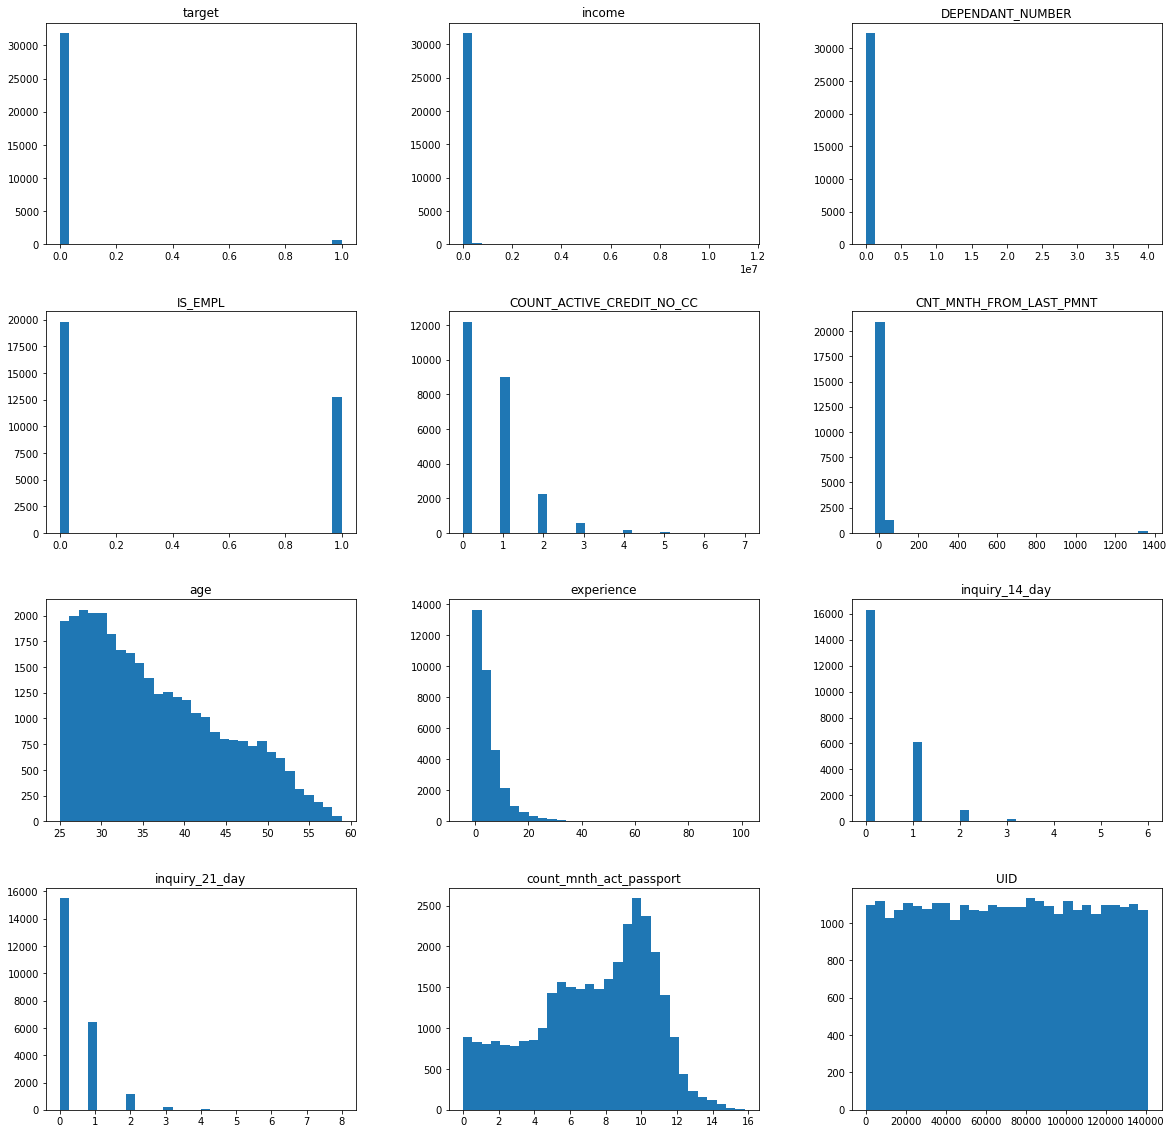

In [724]:
df_hist = df_accept.hist(bins=30, figsize=(20, 20), grid=False)

#### Видно, что в категориальных переменных нет выбросов или аномальных значений:

In [725]:
for col in df_accept.select_dtypes(include=["object"]):
    print(df_accept[col].value_counts())

OTHER    21757
2NDFL    10797
Name: INCOME_TYPE, dtype: int64
elementary    21301
advanced       8497
beginner       1543
high           1213
Name: EDUCATION_, dtype: int64
Corporate    12669
VIP            388
Name: CUSTOMER_CATEGORY_, dtype: int64


<center><h3> Информация для reject: </h3></center>

In [726]:
my_info(df_reject.select_dtypes(include=["int64", "float64"]))

,Доля пропущенных значений,Медиана,Среднее,Среднеквадратическое отклонение
income,5.106144,29115.000000,33651.242633,21821.837966
DEPENDANT_NUMBER,0.046760,0.000000,0.001778,0.046357
IS_EMPL,0.000000,1.000000,0.543253,0.498149
COUNT_ACTIVE_CREDIT_NO_CC,41.223230,0.000000,0.540971,0.730867
CNT_MNTH_FROM_LAST_PMNT,51.126905,0.864539,42.478167,228.831924
age,0.000000,24.109290,24.037108,0.738261
experience,0.074815,1.225735,1.660079,1.394135
inquiry_14_day,43.056205,0.000000,0.340614,0.619647
inquiry_21_day,43.056205,0.000000,0.414025,0.708179
count_mnth_act_passport,0.000000,3.713115,3.509274,1.154384


In [727]:
categorical_info(df_reject.select_dtypes(include=["object"]))

,Доля пропущенных значений,Мода
INCOME_TYPE,0,OTHER
EDUCATION_,0,elementary
CUSTOMER_CATEGORY_,47.1523,Corporate


#### Видно что в столбце CNT_MNTH_FROM_LAST_PMNT есть значение около 1400, что является выбросом. Также в столбце COUNT_ACTIVE_CREDIT_NO_CC есть редкие значения 4-6. В столбце inquiry_21_day есть значения 3. Есть также какое-то аномальное значение в CNT_MNTH_FROM_LAST_PMNT, стоит отрицательное число. И выброс в столбце count_mnth_act_passport, там значение 43.

In [728]:
df_reject.select_dtypes(include=["int64", "float64"]).describe().transpose()

,count,mean,std,min,25%,50%,75%,max
income,10147.0,33651.242633,21821.837966,0.000000,20787.500000,29115.000000,40318.000000,434136.000000
DEPENDANT_NUMBER,10688.0,0.001778,0.046357,0.000000,0.000000,0.000000,0.000000,2.000000
IS_EMPL,10693.0,0.543253,0.498149,0.000000,0.000000,1.000000,1.000000,1.000000
COUNT_ACTIVE_CREDIT_NO_CC,6285.0,0.540971,0.730867,0.000000,0.000000,0.000000,1.000000,6.000000
CNT_MNTH_FROM_LAST_PMNT,5226.0,42.478167,228.831924,-31.072849,0.506989,0.864539,1.849322,1364.633401
age,10693.0,24.037108,0.738261,0.002732,23.547945,24.109290,24.581967,24.999873
experience,10685.0,1.660079,1.394135,0.024590,0.602425,1.225735,2.249315,15.271233
inquiry_14_day,6089.0,0.340614,0.619647,0.000000,0.000000,0.000000,1.000000,6.000000
inquiry_21_day,6089.0,0.414025,0.708179,0.000000,0.000000,0.000000,1.000000,8.000000
count_mnth_act_passport,10693.0,3.509274,1.154384,0.002740,3.063852,3.713115,4.292350,43.098630


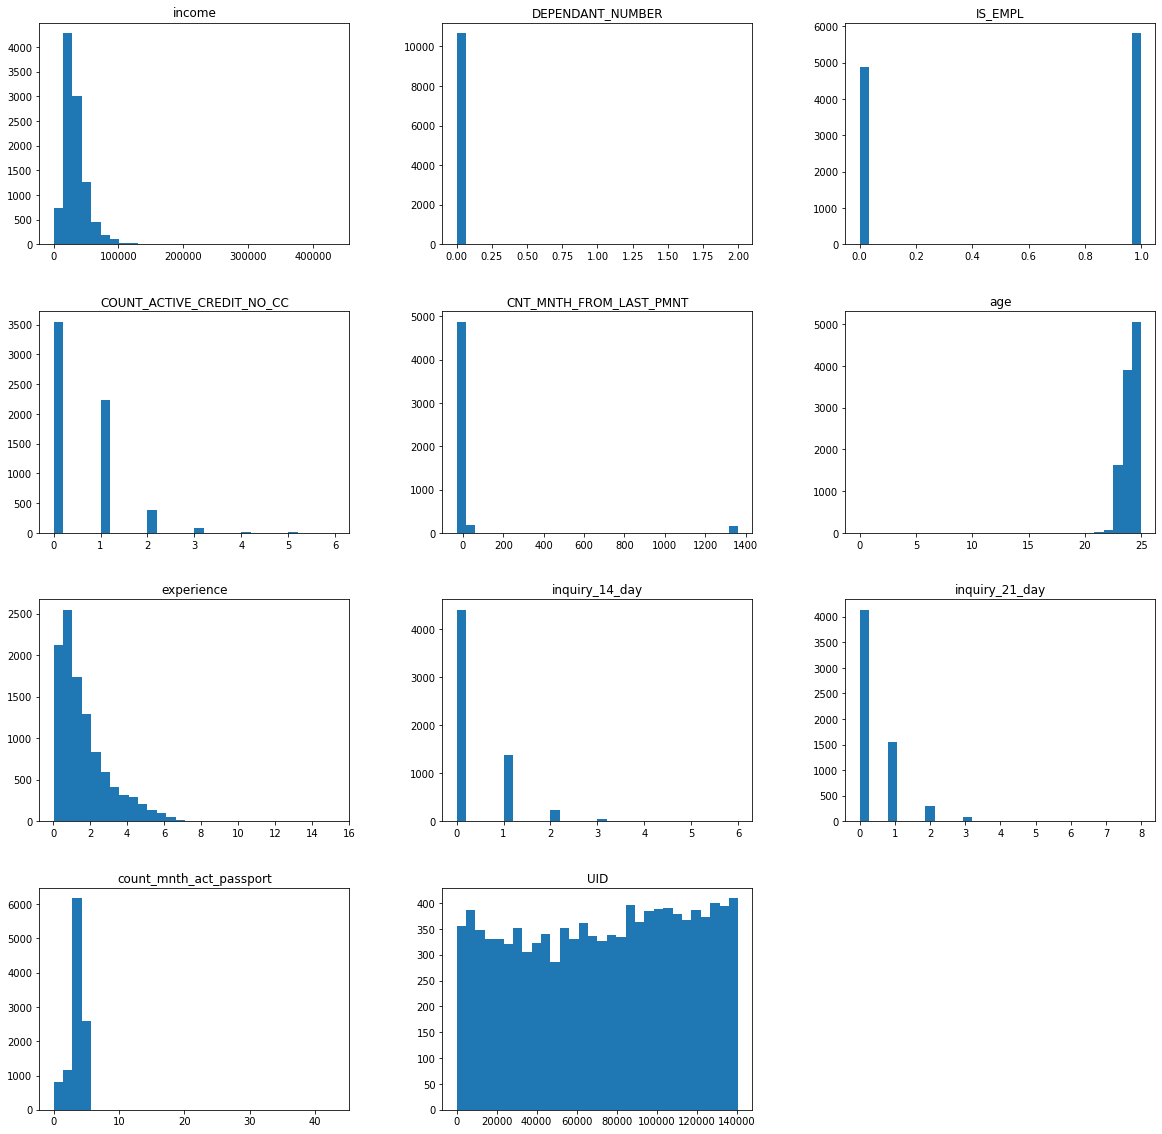

In [729]:
df_hist = df_reject.hist(bins=30, figsize=(20, 20), grid=False)

#### Видно, что есть выбросы в колонке EDUCATION, значение "VIP" - слишком редкое там:

In [730]:
for col in df_reject.select_dtypes(include=["object"]):
    print(df_reject[col].value_counts())

OTHER    6684
2NDFL    4009
Name: INCOME_TYPE, dtype: int64
elementary    6778
advanced      2457
high          1175
beginner       283
Name: EDUCATION_, dtype: int64
Corporate    5640
VIP            11
Name: CUSTOMER_CATEGORY_, dtype: int64


### 5. Построение модели для предсказаний ответов (reject inference) на reject

In [731]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

In [732]:
X = pd.read_csv("17_accept.csv")

In [733]:
y = X.target

In [734]:
X = X.drop(columns = ["target"])

In [735]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [736]:
forest = RandomForestClassifier(max_depth=None, n_estimators=70, max_features="log2")

In [737]:
categorical = list(X_train.select_dtypes(include=["object"]).columns)
numeric = list(X_train.select_dtypes(include=["int64", "float64"]).columns)

In [738]:
numeric_transformer = Pipeline(steps=[
    ("fillna_num", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler()),
])

categorical_transformer = Pipeline(steps=[
    ("fillna", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore")),
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric),
        ("cat", categorical_transformer, categorical),
    ]
)

pipeline = Pipeline(
    steps=[
        ("preproc", preprocessor),
        (
            "Forest",
            forest,
        ),
    ]
)

In [739]:
model = pipeline.fit(X_train, y_train)

In [740]:
f1_score(model.predict(X_test), y_test)

0.21656050955414016

In [741]:
model = pipeline.fit(X, y)

In [742]:
df_temp = df_reject.copy()

In [743]:
df_temp["target"] = model.predict_proba(df_reject)[:, 1]

In [744]:
df_temp["target"] = np.where(df_temp["target"] > 0.13, 1, 0)

In [745]:
100 * (df_temp.target.value_counts()[1] / df_temp.target.value_counts()[0])

3.9467288811120835

In [746]:
X = pd.read_csv("17_accept.csv")

In [747]:
df_extended = X.append(df_temp)

In [748]:
100 * (df_extended.target.value_counts()[1] / df_extended.target.value_counts()[0])

2.6172171602126046

#### WOE and IV

In [749]:
cols = list(df_extended.select_dtypes(include=["object"]).columns)
cols.append("target")

for col in cols[:-1]:
    print(woe_iv(df_extended[cols], col), "\n")

target              0         1       woe        iv
INCOME_TYPE                                        
2NDFL        0.342184  0.349048  0.019861  0.000208
OTHER        0.657816  0.650952 -0.010490  0.000208 

target             0         1       woe        iv
EDUCATION_                                        
advanced    0.251685  0.314597  0.223114  0.070508
beginner    0.042473  0.032638 -0.263393  0.070508
elementary  0.651955  0.546691 -0.176092  0.070508
high        0.053887  0.106074  0.677257  0.070508 

target                     0         1       woe        iv
CUSTOMER_CATEGORY_                                        
Corporate           0.978585  0.988235  0.009814  0.005876
VIP                 0.021415  0.011765 -0.599010  0.005876 



In [750]:
cols = list(df_extended.select_dtypes(include=["int64", "float64"]).columns)
num_cols_iv = []

for col in cols:
    num_cols_iv.append(str(col) + "_range")
    df_extended[str(col) + "_range"] = pd.cut(df_extended[col], bins=10, include_lowest=True)

In [751]:
num_cols_iv.append("target")
num_cols_iv.remove('target_range')

In [752]:
import warnings

with warnings.catch_warnings(record=True):
    for col in num_cols_iv[:-1]:
        print(woe_iv(df_extended, col), "\n")

target                           0    1      woe            iv
income_range                                                  
(-11450.379, 1145037.8]   0.999780  1.0  0.00022  4.823088e-08
(1145037.8, 2290075.6]    0.000171  0.0  0.00000  4.823088e-08
(3435113.4, 4580151.2]    0.000024  0.0  0.00000  4.823088e-08
(10305340.2, 11450378.0]  0.000024  0.0  0.00000  4.823088e-08 

target                         0         1       woe        iv
DEPENDANT_NUMBER_range                                        
(-0.005, 0.4]           0.995776  0.985728 -0.010142  0.013374
(0.8, 1.2]              0.003203  0.012369  1.351001  0.013374
(1.6, 2.0]              0.000831  0.001903  0.829126  0.013374
(2.8, 3.2]              0.000142  0.000000  0.000000  0.013374
(3.6, 4.0]              0.000047  0.000000  0.000000  0.013374 

target                0         1       woe        iv
IS_EMPL_range                                        
(-0.002, 0.1]  0.561931  0.920218  0.493232  0.786908
(0.9, 1.0]     

### 4. Построить логистическую регрессию только на одобренных заявках с преобразованными переменными WoE. Какое значение GINI? F1 мера?

In [753]:
df_accept = pd.read_csv("17_accept.csv")
df_reject = pd.read_csv("17_reject.csv")

In [754]:
def get_WOE(df, feature, target):
    lst = []

    unique_values = df[feature].unique()
    for val in unique_values:
        lst.append(
            [
                feature,
                val,
                df[(df[feature] == val) & (df[target] == 0)].count()[feature],
                df[(df[feature] == val) & (df[target] == 1)].count()[feature],
            ]
        )

    data = pd.DataFrame(lst, columns=["Variable", "Value", "Good", "Bad"])

    total_bad = df[df[target] == 1].count()[feature]
    total_good = df.shape[0] - total_bad

    data["Distribution Good"] = data["Good"] / total_good
    data["Distribution Bad"] = data["Bad"] / total_bad
    data["WoE"] = np.log(data["Distribution Good"] / data["Distribution Bad"])

    data = data.replace({"WoE": {np.inf: 0, -np.inf: 0}})

    data = data.sort_values(by=["Variable", "Value"], ascending=[True, True])
    data.index = range(len(data.index))

    return data

In [755]:
cols = list(df_accept.select_dtypes(include=["int64", "float64"]).columns)
num_cols_iv = []

for col in cols:
    num_cols_iv.append(str(col) + "_range")
    df_accept[str(col) + "_range"] = pd.cut(df_accept[col], bins=10, include_lowest=True)

In [756]:
num_cols_iv.remove("target_range")

In [757]:
num_cols_iv.append("target")

In [758]:
for col in num_cols_iv[:-1]:
    df_temp = get_WOE(df_accept[num_cols_iv], col, "target")
    temp_dict = pd.Series(df_temp.WoE.values, index=df_temp.Value.astype(str)).to_dict()
    df_accept[col] = df_accept[col].astype(str).map(temp_dict)

/home/alexander/PythonProjects/MO/venb/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/alexander/PythonProjects/MO/venb/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [759]:
X = df_accept[num_cols_iv]

In [760]:
y = X.target

In [761]:
X = X.drop(columns = ["target"])

In [762]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

In [763]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

In [764]:
logreg = LogisticRegression(C=12)

In [793]:
numeric = num_cols_iv
numeric.remove("target")
categorical = []

In [772]:
numeric_transformer = Pipeline(steps=[
    ("fillna_num", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler()),
])

categorical_transformer = Pipeline(steps=[
    ("fillna", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore")),
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric),
        ("cat", categorical_transformer, categorical),
    ]
)

pipeline = Pipeline(
    steps=[
        ("preproc", preprocessor),
        (
            "logreg",
            logreg,
        ),
    ]
)

In [773]:
model = pipeline.fit(X_train, y_train)

In [774]:
roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

0.7404022060801723

In [775]:
print("GINI = " + str(2 * roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]) - 1))

GINI = 0.48080441216034453


In [776]:
f1_score(y_test, model.predict(X_test))

0.0273972602739726

### 6. Построить логистическую регрессию на всех заявках с преобразованными переменными WoE. Какое значение GINI, F1? Изменилась ли модель? 

In [777]:
cols = list(df_extended.select_dtypes(include=["int64", "float64"]).columns)
num_cols_iv = []

for col in cols:
    num_cols_iv.append(str(col) + "_range")
    df_extended[str(col) + "_range"] = pd.cut(df_extended[col], bins=20, include_lowest=True)

In [778]:
num_cols_iv.remove("target_range")

In [779]:
num_cols_iv.append("target")

In [780]:
for col in num_cols_iv[:-1]:
    df_temp = get_WOE(df_extended[num_cols_iv], col, "target")
    temp_dict = pd.Series(df_temp.WoE.values, index=df_temp.Value.astype(str)).to_dict()
    df_extended[col] = df_extended[col].astype(str).map(temp_dict)

/home/alexander/PythonProjects/MO/venb/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/alexander/PythonProjects/MO/venb/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [781]:
X = df_extended[num_cols_iv]

In [782]:
y = X.target

In [783]:
X = X.drop(columns = ["target"])

In [784]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

In [785]:
logreg = LogisticRegression(C=20)

In [786]:
numeric_transformer = Pipeline(steps=[
    ("fillna_num", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler()),
])

categorical_transformer = Pipeline(steps=[
    ("fillna", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore")),
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric),
        ("cat", categorical_transformer, categorical),
    ]
)

pipeline = Pipeline(
    steps=[
        ("preproc", preprocessor),
        (
            "logreg",
            logreg,
        ),
    ]
)

In [787]:
numeric = num_cols_iv
numeric.remove("target")

In [788]:
categorical = []

In [789]:
model = pipeline.fit(X_train, y_train)

In [790]:
roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

0.7937830259894316

In [791]:
print("GINI = " + str(2 * roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]) - 1))

GINI = 0.5875660519788632


In [792]:
f1_score(y_test, model.predict(X_test))

0.017699115044247787